## Biodiversity Intactness Index Change in Phoenix Subdivision
Author: Carly Caswell

Repository: https://github.com/ccaswell25/eds220-phoenix-project

## About

### Purpose

Analyzing biodiversity changes in Phoenix, Arizona from 2017 to 2020 by utilizing the Biodiversity Intactness Index (BII). 

### Highlights

-Geospatial data exploration 

-Data analysis calculating the percentage of area 

-Creating and customizing a map of biodiversity lost from 2017 to 2020

### Dataset Description and References

**Dataset 1**

Using Biodiversity Intactness Index (BII) data. This dataset is part of the MPC STAC catalog under the 'io-biodiversity' collection. Using 2017 and 2020 rasters with a Phoenix subdivision bounding box. 


**Dataset 2**

Using a Phoenix subdivision polygon from the Census County Subdivision shapefiles for Arizona. Data Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions



In [109]:
#Import Libraries
import os
import numpy as np 
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from shapely.geometry import Polygon

#Used to access the STAC catalogs:
from pystac_client import Client

#Used to sign (requesting further access) items from the MPC catalog:
import planetary_computer

#Other libraries for nice outputs:
from IPython.display import Image 

#importing contextily package for maps
import contextily as ctx

## Let's Access The Datasets Below:


In [110]:
#Loading the planetary computer catalog:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", 
                      modifier = planetary_computer.sign_inplace)

#The temporal range of interest:
time_range = '2017/2020'

#Bounding Box Coordinates (as a GeoJSON):
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]


#Catalog search for the biodiversity collection:
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)

items = search.item_collection()

#Number of items in the search:
len(items)

#Viewing items to see which items I want:
items

#Indexing to only look at the years I need (2017 and 2020):
bii_2020 = items[0]
bii_2017 = items[3]


In [111]:
bii_2020.assets.keys()
bii_2020_data = rioxr.open_rasterio(bii_2020.assets['data'].href)

#dropping extra dimension:
bii_2020_data = bii_2020_data.squeeze()
#dropping extra coordinates:
bii_2020_data = bii_2020_data.drop('band')

In [112]:
bii_2017.assets.keys()
bii_2017_data = rioxr.open_rasterio(bii_2017.assets['data'].href)
bii_2017_data

#dropping extra dimension:
bii_2017_data = bii_2017_data.squeeze()
#dropping extra coordinates:
bii_2017_data = bii_2017_data.drop('band')

In [113]:
#Arizona Data
az = gpd.read_file(os.path.join(os.getcwd(), 'data', 'tl_2022_04_cousub.shp'))

#Checking out the data
az.head()

#Filtering to just Phoenix:
phx = az[az.NAME == 'Phoenix']
phx

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,NaN,NaN,NaN,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


## Mapping Phoenix Subdivision

In [114]:
#I want to use Open Street MAp from basemap, so I want to see what keys are available:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

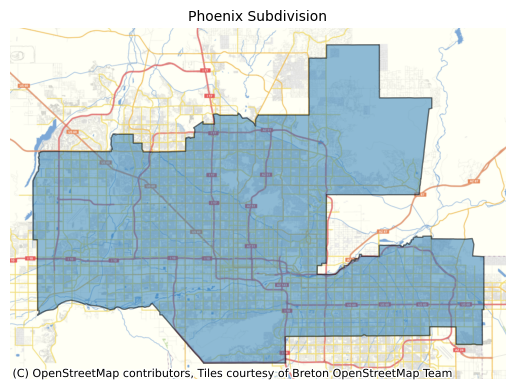

In [115]:
fig, ax = plt.subplots()
(phx.to_crs(epsg=3857)
 .plot(ax=ax, figsize =(10,10), alpha =0.5, edgecolor="k")
)

#Adding Basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.BZH) #setting the background map using Open Street Map
ax.set_title('Phoenix Subdivision', fontdict = {'fontsize':'10'})
ax.set_axis_off()

## Data Analysis
### Finding the Percentage of Phoenix with a BII of at least .75 for 2017 and 2020 

In [116]:
type(pixels_above_threshold_2017)

xarray.core.dataarray.DataArray

In [117]:
#Finding data according to the threshold:
bii_threshold = 0.75
pixels_above_threshold_2017 = bii_2017_data >= bii_threshold
pixels_above_threshold_2020 = bii_2020_data >= bii_threshold

#Converting to integer data array
pixels_above_threshold_2017 = pixels_above_threshold_2017.astype(int)
pixels_above_threshold_2020 = pixels_above_threshold_2020.astype(int)

#Calculating the total number of pixels in the Phoenix subdivision for each year
total_pixels_2017 = np.sum(bii_2017_data)
total_pixels_2017

total_pixels_2020 = np.sum(bii_2020_data)
total_pixels_2020

#Calculating the percentage of pixels with a BII of at least 0.75
percentage_2017 = (np.sum(pixels_above_threshold_2017) / total_pixels_2017) * 100
percentage_2020 = (np.sum(pixels_above_threshold_2020) / total_pixels_2020) * 100

print(f"Percentage of area with BII >= 0.75 in 2017: {percentage_2017:.2f}%")
print(f"Percentage of area with BII >= 0.75 in 2020: {percentage_2020:.2f}%")

Percentage of area with BII >= 0.75 in 2017: 91.13%
Percentage of area with BII >= 0.75 in 2020: 91.02%


In [118]:
#identify lost pixels:
lost_pixels = pixels_above_threshold_2017 - pixels_above_threshold_2020
print(np.sum(lost_pixels)) #I can see there are a high number of pixels lost 

<xarray.DataArray ()>
array(96266)
Coordinates:
    spatial_ref  int64 0


In [149]:
#need to make sure my crs's are the same
phx = phx.to_crs(lost_pixels.rio.crs)
#checking to make sure the crs's match
phx.crs == lost_pixels.rio.crs

#clipping the bii data to the phoenix geometry
lost_pixels = lost_pixels.rio.clip(phx.geometry, phx.crs)
pixels_above_threshold_2020 = pixels_above_threshold_2020.rio.clip(phx.geometry, phx.crs)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


## Data Visualization
Let's show the area with BII>=0.75 in 2017 that was lost by 2020.


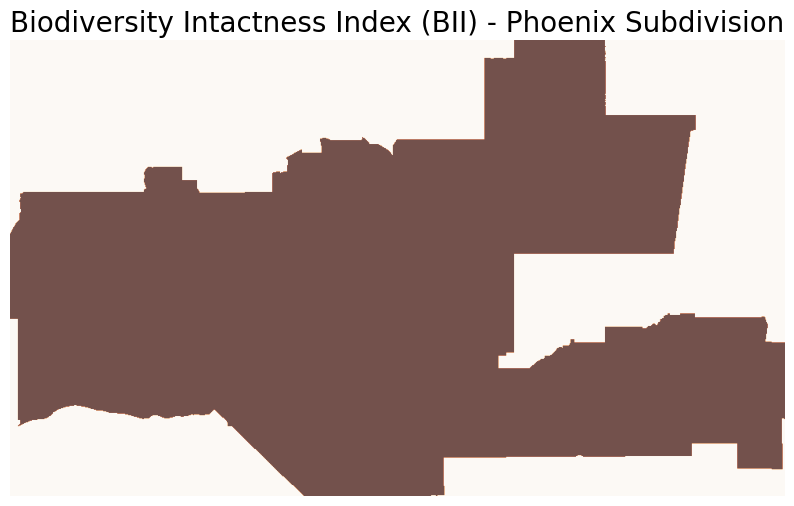

In [163]:
#Let's plot the data 
fig, ax = plt.subplots(figsize=(10, 10))
phx.plot(ax=ax, edgecolor="black")

# Overlay pixels_above_threshold_2020

ax.imshow(pixels_above_threshold_2020,cmap='Greens', alpha = .5)
ax.imshow(lost_pixels, cmap='Reds', alpha = .5)
ax.set_title('Biodiversity Intactness Index (BII) - Phoenix Subdivision', fontdict = {'fontsize':'20'})
ax.set_axis_off()
plt.show()

#legend_elements = [mlines.Line2D([0], [0], color='red', label='Area with BII >= 0.75 lost from 2017 to 2020')]

# Add legend
#ax.legend(handles=legend_elements)


In [121]:
#to add later ....
# Overlay 2017 BII >= 0.75
#ax.imshow(pixels_above_threshold_2017, cmap='Blues', interpolation='none', extent=phx.geometry.total_bounds, alpha=0.5)

# Overlay 2020 BII >= 0.75
#ax.imshow(pixels_above_threshold_2020, cmap='Greens', interpolation='none', extent=phx.geometry.total_bounds, alpha=0.5)

# Overlay lost pixels
#ax.imshow(lost_pixels, cmap='Reds', interpolation='none', extent=phx.geometry.total_bounds, alpha=0.5)

#plt.show()